In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from cStringIO import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time


In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_GK.txt"
pcCatalog = "koiCatalogs/dr25_GK_PCs.csv"

period_rng = (50, 400)
n_period = 57
rp_rng = (0.75, 2.5)
n_rp = 61

# for quick tests
# nWalkers = 6
# nBurnin = 200
# nMcmc = 1000
# for production runs
nWalkers = 16
nBurnin = 1000
nMcmc = 5000


model = "dualPowerLawGap"

In [3]:

def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))
    if model == "dualPowerLawGap":
        f0, alpha, beta, gd, gw = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        gapSlope = -0.13
        gapOffset = 0.41

#        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    else:
        raise ValueError('Bad model name');
        
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F$", r"$\beta$", r"$\alpha$"]
    if model == "dualPowerLawGap":
        return [r"$F$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$"]

    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    if model == "dualPowerLawGap":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.5
        theta = [f0, alpha, beta, gd, gw]
    else:
        raise ValueError('Bad model name');
  
    return theta

def lnPoisprior(theta, model):
    if model == "dualPowerLaw":
        if 0.0 <= theta[0] <= 1 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0:
            return 1.0
    if model == "dualPowerLawGap":
        if 0.0 <= theta[0] <= 1 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0 \
        and 0 <= theta[3] < 1 \
        and 0.2 <= theta[4] < 0.8:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf


In [4]:
def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]


def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) + "+{:.3f}".format(e[1]) + "-{:.3f}".format(e[2])



In [5]:
from scipy.integrate import romb

def integrate2DGrid(g, dx, dy):
    if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
        raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return romb(romb(g, dx), dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 2**5+1 # must be 2**n + 1
    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nPts), 
                                       np.linspace(rpRange[0], rpRange[1], nPts), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret


def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nP), 
                                       np.linspace(rpRange[0], rpRange[1], nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)






In [6]:
# population inference functions

def lnlike(theta):
    pop = rateModel(period_grid, rp_grid, period_rng, rp_rng, theta, model) * summedCompleteness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta, model))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
def lnprob(theta):
    lp = lnPoisprior(theta, model)
    if not np.isfinite(lp):
        return -np.inf

    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15


In [7]:
# population analysis functions

# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
#    print("in make_plot, pop_comp:")
#    print(pop_comp.shape)

    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
#    print("pop:")
#    print(pop.shape)
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    
    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))

    for i, p in enumerate(samples):
        pop[i] = rateModel(period_grid, rp_grid, period_rng, rp_rng, p, model)
        gamma_earth[i] = rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    fsize = 18
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * summedCompleteness[None, :, :], rp, x, period, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$", fontsize = fsize)
    
    # Integrate over period.
    dx = 31.25
    x = np.arange(period_rng[0], period_rng[1] + dx, dx)
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * summedCompleteness[None, :, :], 1, 2), period, x, rp, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$", fontsize = fsize)
    
                
    return gamma_earth, fig


In [8]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
m &= np.isfinite(base_kois.corrected_prad) & (rp_rng[0] <= base_kois.corrected_prad) & (base_kois.corrected_prad <= rp_rng[1])
kois = pd.DataFrame(base_kois[m])
allKois = kois


(50, 400)

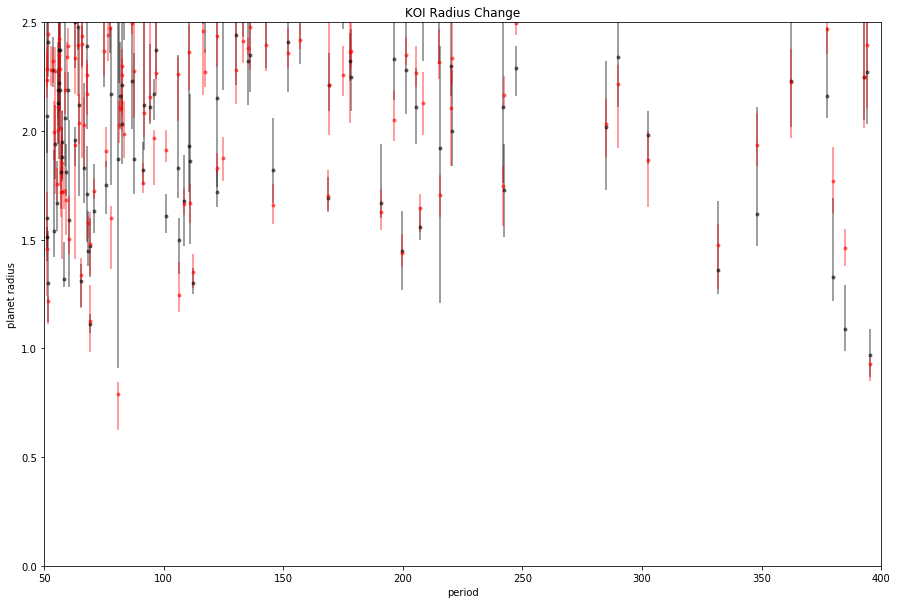

In [9]:
fig, ax = plt.subplots(figsize=(15,10));
ax.errorbar(kois.koi_period, kois.koi_prad, 
            yerr = [-kois.koi_prad_err2, kois.koi_prad_err1],
            fmt="k.", alpha = 0.5);
ax.errorbar(kois.koi_period, kois.corrected_prad, 
            yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
            fmt="r.", alpha = 0.5);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Radius Change");
plt.ylim([0, 2.5])
plt.xlim([50, 400])




In [10]:
period = np.linspace(period_rng[0], period_rng[1], n_period)
rp = np.linspace(rp_rng[0], rp_rng[1], n_rp)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape



In [11]:

inputgrid = "../completenessContours/out_sc0_GK_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

# interpolate the numerical grids onto the period_grid, rp_grid space
#print("size probtot = " + str(np.shape(probtot)))
#print("size period_want = " + str(np.shape(period_want)))
#print("size rp_want = " + str(np.shape(rp_want)))

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)


In [12]:
summedCompleteness = numCompVeInterp(period, rp)




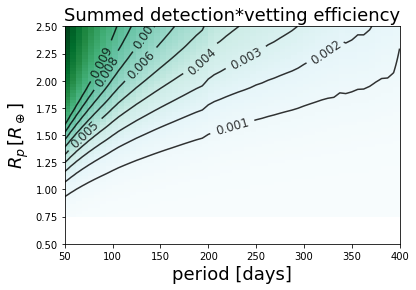

In [13]:

contourLevels = np.arange(1e-3, 1e-2, 1e-3)

plt.pcolor(period_grid, rp_grid, summedCompleteness, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedCompleteness / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
plt.ylim(0.5, 2.5)
plt.xlim(50, 400)
plt.clabel(c, fontsize=12, inline=1, fmt="%.3f")
plt.title("Summed detection*vetting efficiency", fontsize = 18)
plt.xlabel("period [days]", fontsize = 18)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 18);
plt.savefig("summedCompleteness.eps",bbox_inches='tight')




Compute a basic occurrence rate without reliability

/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


[ 0.75 -0.69 -0.1   0.22  0.5 ]


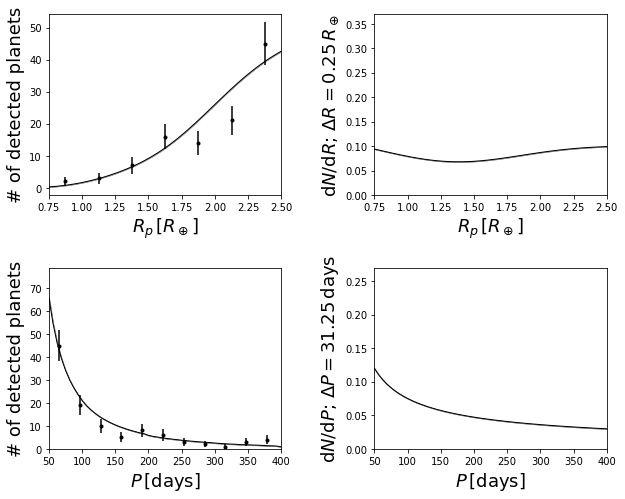

In [14]:
kois = allKois

if model == "dualPowerLaw":
    bounds = [(-5, 5), (-5, 5), (-5, 5)]
if model == "dualPowerLawGap":
    bounds = [(-5, 5), (-5, 5), (-5, 5), (0, 1), (0.2, 0.8)]

# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(kois.corrected_prad)
vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]

theta_0 = initRateModel(model)
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r.x)
ge, fig = plot_results(r.x);



In [15]:
rateModel(365.25, 1.0, period_rng, rp_rng, theta_0, model)*365

0.18646724996749686

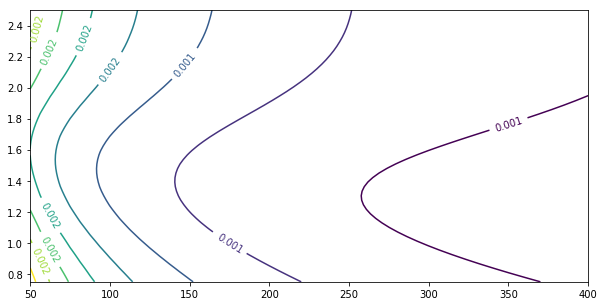

In [16]:
fig, ax = plt.subplots(figsize=(10,5));

rateGrid = rateModel(period_grid, rp_grid, period_rng, rp_rng, theta_0, model)
CS = ax.contour(period_grid, rp_grid, rateGrid);
ax.clabel(CS, inline=1, fontsize=10);




In [17]:

##################################################################


ndim, nwalkers = len(r.x), nWalkers
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnin)
sampler.reset()

# Production.
start_time = time.time()
pos, _, _ = sampler.run_mcmc(pos, nMcmc)
print("--- %s seconds ---" % (time.time() - start_time))

kois.to_csv("occurenceRatePosteriors/selectedPcs_noreliability.csv")

samples_noreliability = sampler.flatchain   
np.save("occurenceRatePosteriors/occurenceRatePosteriors_noreliability.npy", samples_noreliability)


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value enc

--- 38.9968979359 seconds ---


0.23519889483773312


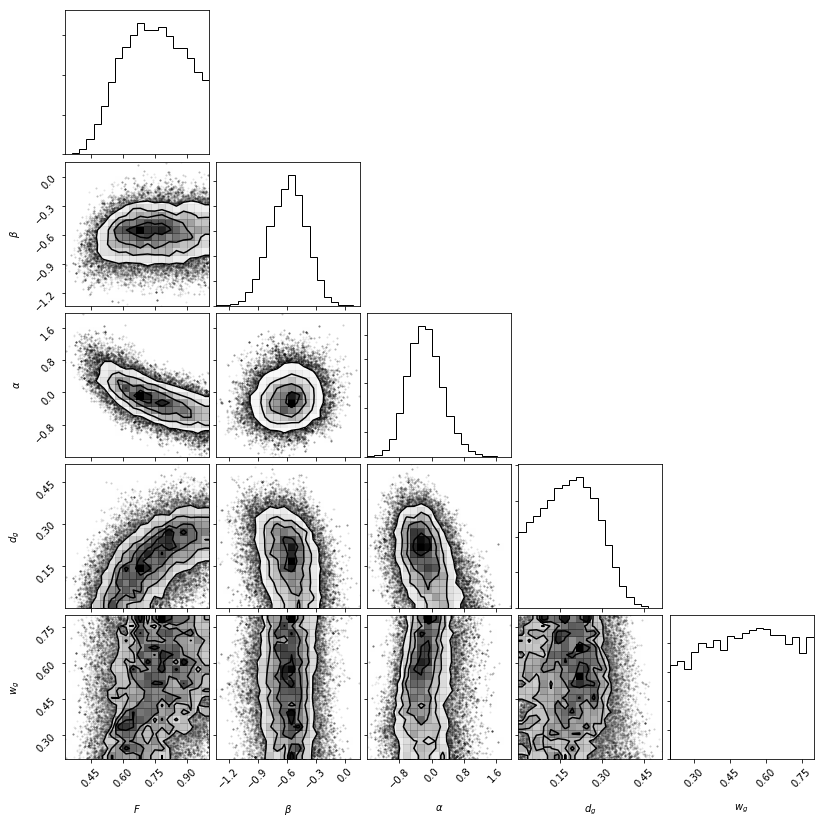

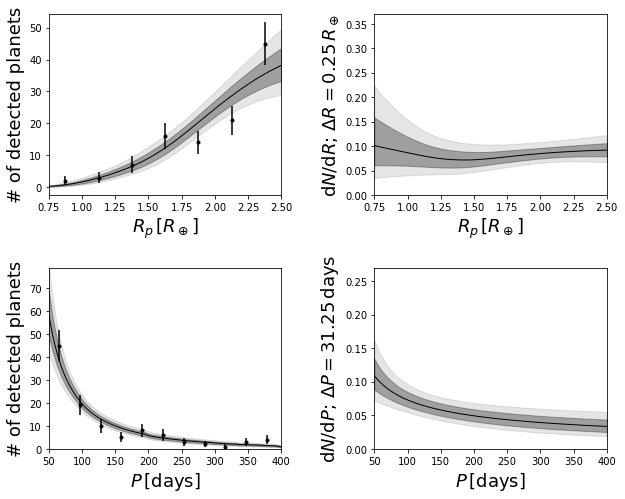

In [18]:
##################################################################
##################################################################

corner.corner(samples_noreliability, labels=getModelLabels(model));

##################################################################

gamma_earth_no_reliability, fig = plot_results(samples_noreliability)
print(np.mean(gamma_earth_no_reliability))

##################################################################



In [19]:
print(np.median(samples_noreliability,0))

[ 0.74145387 -0.58078602 -0.17359946  0.18161598  0.51699263]


Mean Gamma_Earth = 0.217102742076


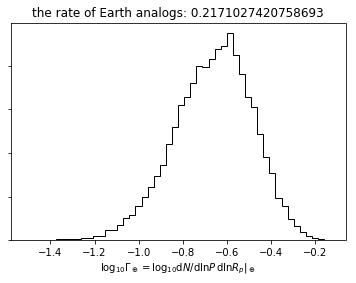

In [20]:

plt.hist(np.log10(gamma_earth_no_reliability), 50, histtype="step", color="k", density=True)
plt.gca().set_yticklabels([])
plt.title("the rate of Earth analogs: " + str(10**np.mean(np.log10(gamma_earth_no_reliability))))
plt.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");

print("Mean Gamma_Earth = {0}".format(10**np.mean(np.log10(gamma_earth_no_reliability))))



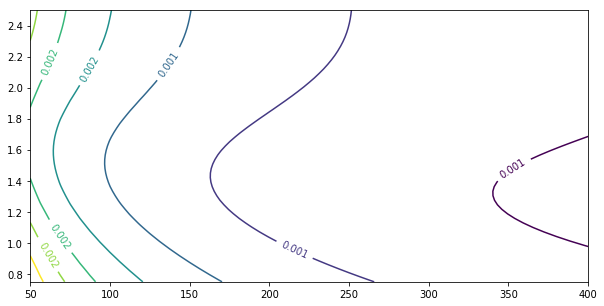

In [21]:
fig, ax = plt.subplots(figsize=(10,5));

rateGrid = rateModel(period_grid, rp_grid, period_rng, rp_rng, np.median(samples_noreliability, 0), model)
CS = ax.contour(period_grid, rp_grid, rateGrid);
ax.clabel(CS, inline=1, fontsize=10);

Compute an occurrence rate with reliability

In [22]:
nTrials = 100

f = FloatProgress(min=0, max=nTrials)
display(f)

allKois = kois
for mCount in range(nTrials):
    # randomly select kois
    
#    koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
    koiSelect = (np.random.rand(len(allKois)) < allKois.reliability)
    kois = allKois[koiSelect]
    kois.to_csv("occurenceRatePosteriors/selectedPcs" + str  (mCount) + ".csv")
#    print(str(mCount) + " of " + str(nTrials) + ", selected " + str(len(kois)) 
#          + " kois out of " + str(len(allKois)) + " after reliability cut")
    
    koi_periods = np.array(kois.koi_period)
    koi_rps = np.array(kois.corrected_prad)

    theta_0 = initRateModel(model)
    r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
    # initPos = r.x
    initPos = np.median(samples_noreliability,0);
    ##################################################################


    ndim, nwalkers = len(r.x), 10
    pos = [initPos + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, 400)
    sampler.reset()

    # Production.
    pos, _, _ = sampler.run_mcmc(pos, 1000)

    samples = sampler.flatchain   
    np.save("occurenceRatePosteriors/occurenceRatePosteriors_" + str(mCount) + ".npy", samples)
    
    f.value += 1



FloatProgress(value=0.0)

/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


In [23]:
import gc # for memory management

f = FloatProgress(min=0, max=nTrials)
display(f)

for mCount in range(nTrials):
    samples = np.load("occurenceRatePosteriors/occurenceRatePosteriors_" + str(mCount) + ".npy");
    
    subsampleFactor = int(np.round(nTrials/4))
    if mCount == 0:
        allSamples = samples[0:-1:subsampleFactor,:]
    else:
        allSamples = np.concatenate((allSamples, samples[0:-1:subsampleFactor,:]))
    gc.collect() # force garbage collection before loading another one
    f.value += 1


FloatProgress(value=0.0)

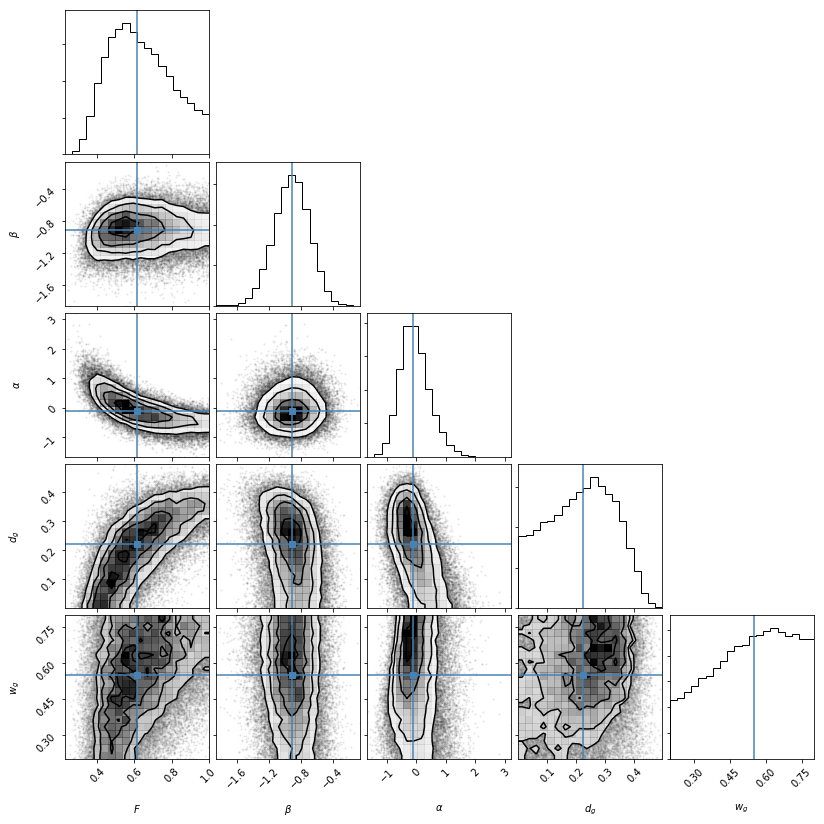

In [24]:
corner.corner(allSamples, labels=getModelLabels(model), truths = np.median(allSamples, 0));
plt.savefig("mcmcSampleDist.eps",bbox_inches='tight')




In [25]:
print(np.median(allSamples, 0))

[ 0.61605553 -0.91424092 -0.09755439  0.22190859  0.55142071]


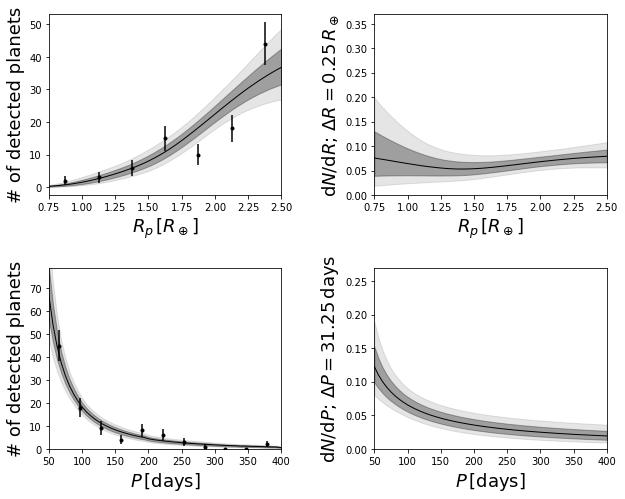

In [26]:
gamma_earth, fig = plot_results(allSamples)
plt.savefig("planetResults.eps",bbox_inches='tight')




In [27]:
import scipy.stats as stats

modes = np.zeros(len(np.median(allSamples,0)))
for i in range(len(modes)):
    modes[i] = stats.mode(np.round(allSamples[:,i], 4))[0]
print("modes:")
print(modes)



modes:
[ 0.5093 -0.9532 -0.2664  0.294   0.5687]


In [28]:
bestTheta = np.median(allSamples, 0)
bestTheta[3] = modes[3]
# bestTheta[4] = modes[4]



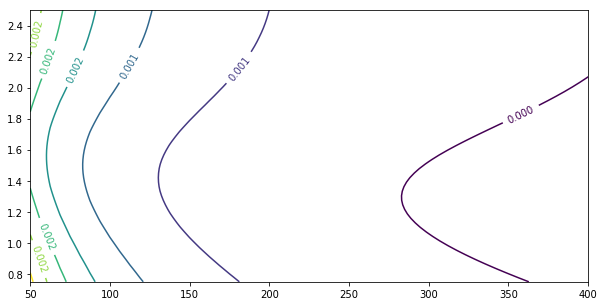

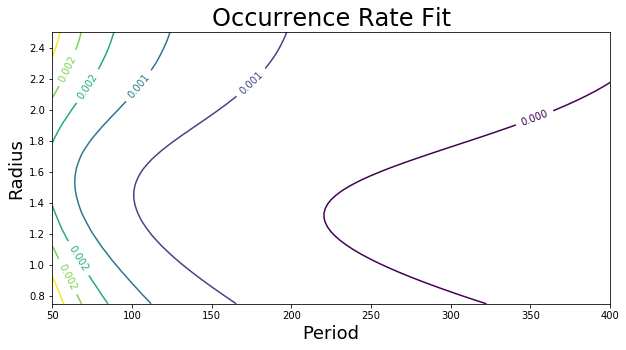

In [29]:
fig, ax = plt.subplots(figsize=(10,5));
rateGrid = rateModel(period_grid, rp_grid, period_rng, rp_rng, np.median(allSamples, 0), model)
CS = ax.contour(period_grid, rp_grid, rateGrid);
ax.clabel(CS, inline=1, fontsize=10);

fig, ax = plt.subplots(figsize=(10,5));
rateGrid = rateModel(period_grid, rp_grid, period_rng, rp_rng, bestTheta, model)
CS = ax.contour(period_grid, rp_grid, rateGrid);
ax.clabel(CS, inline=1, fontsize=10);
plt.xlabel("Period", fontsize = 18);
plt.ylabel("Radius", fontsize = 18);
plt.title("Occurrence Rate Fit", fontsize = 24);
plt.savefig("valley.eps",bbox_inches='tight')



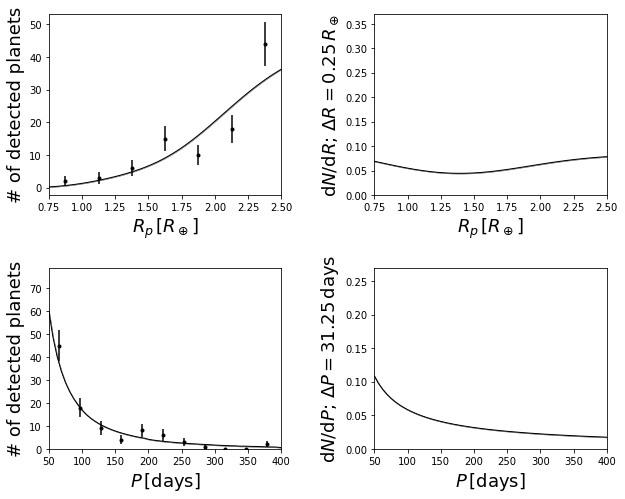

In [30]:
gamma_earth, fig = plot_results(bestTheta)



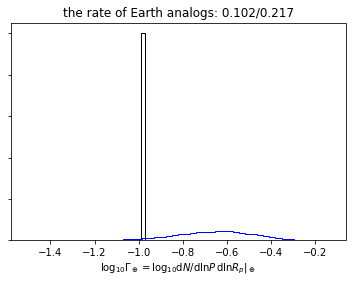

In [31]:
plt.hist(np.log10(gamma_earth), 50, histtype="step", color="k", density=True)
plt.hist(np.log10(gamma_earth_no_reliability), 50, histtype="step", color="b", density=True)
plt.gca().set_yticklabels([])
plt.title("the rate of Earth analogs: " + str(round(10**np.mean(np.log10(gamma_earth)), 3))
    + "/" + str(round(10**np.mean(np.log10(gamma_earth_no_reliability)), 3)))
plt.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");




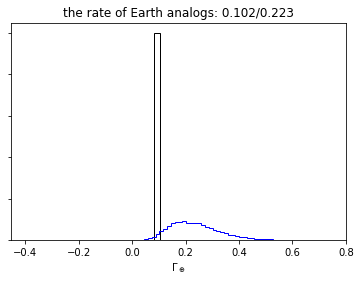

In [32]:
plt.hist(gamma_earth, 50, histtype="step", color="k", density=True)
plt.hist(gamma_earth_no_reliability, 50, histtype="step", color="b", density=True)
plt.gca().set_yticklabels([])
plt.title("the rate of Earth analogs: " + str(round(np.median(gamma_earth), 3))
    + "/" + str(round(np.median(gamma_earth_no_reliability), 3)))
plt.xlabel(r"$\Gamma_\oplus$");




In [33]:
F1Dist = integrateRateModel([50.,200.], [1., 2.], allSamples, model)
F1Dist_nr = integrateRateModel([50.,200.], [1., 2.], samples_noreliability, model)


FloatProgress(value=0.0, max=40000.0)

FloatProgress(value=0.0, max=80000.0)

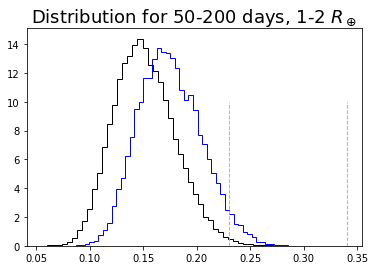

In [34]:
greyLevel = "0.7"
plt.hist(F1Dist, 50, histtype="step", color="k", density=True);
plt.hist(F1Dist_nr, 50, histtype="step", color="b", density=True);
plt.title("Distribution for 50-200 days, 1-2 $R_\oplus$", fontsize=18);
plt.plot([0.34, 0.34], [0, 10], color=greyLevel, linestyle='--', linewidth=1)
plt.plot([0.23, 0.23], [0, 10], color=greyLevel, linestyle='--', linewidth=1)
plt.savefig("f1Dist.eps",bbox_inches='tight')




In [35]:
print("median theta: 1-2Re, 50-200 Days = " + str(integrateRateModel([50.,200.], 
                                               [1., 2.], np.median(allSamples, 0), model)))

print("median theta: 1-2Re, 50-200 Days without reliability = " + str(integrateRateModel([50.,200.], 
                                               [1., 2.], np.median(samples_noreliability, 0), model)))

print("1-2Re, 50-200 Days = " + printMedianAndErrorbars(F1Dist))
print("1-2Re, 50-200 Days without reliability = " + printMedianAndErrorbars(F1Dist_nr))



median theta: 1-2Re, 50-200 Days = 0.15218965114478744
median theta: 1-2Re, 50-200 Days without reliability = 0.17710222824114477
1-2Re, 50-200 Days = 0.149+0.030-0.027
1-2Re, 50-200 Days without reliability = 0.173+0.031-0.028


In [36]:
zetaDist = integrateRateModel([.8*365.25,1.2*365.25], 
                              [0.8,1.2], allSamples, model)
zetaDist_nr = integrateRateModel([.8*365.25,1.2*365.25], 
                              [0.8,1.2], samples_noreliability, model)


FloatProgress(value=0.0, max=40000.0)

FloatProgress(value=0.0, max=80000.0)

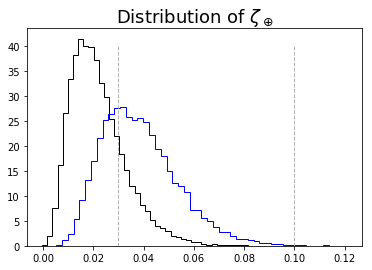

In [37]:
plt.hist(zetaDist, 50, histtype="step", color="k", density=True);
plt.hist(zetaDist_nr, 50, histtype="step", color="b", density=True);
plt.title("Distribution of $\zeta_\oplus$", fontsize=18);
plt.plot([0.1, 0.1], [0, 40], color=greyLevel, linestyle='--', linewidth=1)
plt.plot([0.03, 0.03], [0, 40], color=greyLevel, linestyle='--', linewidth=1)

plt.savefig("zetaEarthDist.eps",bbox_inches='tight')



In [38]:
print("median theta: zeta-Earth = " + str(integrateRateModel([.8*365.25,1.2*365.25], 
                                               [0.8,1.2], np.median(allSamples, 0), model)))

print("median theta: zeta-Earth without reliability = " + str(integrateRateModel([.8*365.25,1.2*365.25], 
                                               [0.8,1.2], np.median(samples_noreliability, 0), model)))

print("zeta-Earth = " + printMedianAndErrorbars(zetaDist))
print("zeta-Earth without reliability = " + printMedianAndErrorbars(zetaDist_nr))





median theta: zeta-Earth = 0.020367130655534256
median theta: zeta-Earth without reliability = 0.03729097280201543
zeta-Earth = 0.020+0.012-0.009
zeta-Earth without reliability = 0.036+0.017-0.013


FloatProgress(value=0.0, max=40000.0)

FloatProgress(value=0.0, max=80000.0)

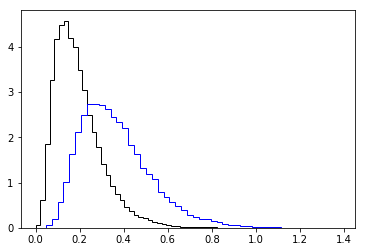

In [39]:
sag13HZDist = integrateRateModel([237,860], [0.5,1.5], allSamples, model)
plt.hist(sag13HZDist, 50, histtype="step", color="k", density=True);
sag13HZDist_nr = integrateRateModel([237,860], [0.5,1.5], samples_noreliability, model)
plt.hist(sag13HZDist_nr, 50, histtype="step", color="b", density=True);

In [40]:
print("median theta: SAG13 HZ = " + str(integrateRateModel([237,860], 
                                               [0.5,1.5], np.median(allSamples, 0), model)))

print("median theta: SAG13 HZ without reliability = " + str(integrateRateModel([237,860], 
                                               [0.5,1.5], np.median(samples_noreliability, 0), model)))

print("SAG13 HZ = " + printMedianAndErrorbars(sag13HZDist))
print("SAG13 HZ without reliability = " + printMedianAndErrorbars(sag13HZDist_nr))



median theta: SAG13 HZ = 0.17303676360276765
median theta: SAG13 HZ without reliability = 0.34416065330958795
SAG13 HZ = 0.172+0.120-0.077
SAG13 HZ without reliability = 0.339+0.180-0.127


FloatProgress(value=0.0, max=40000.0)

FloatProgress(value=0.0, max=80000.0)

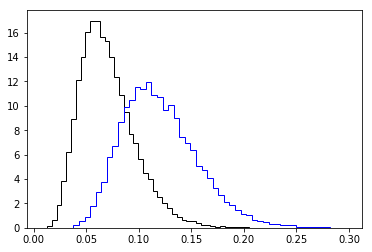

In [41]:
hsuFordDist = integrateRateModel([237,500], [1.0,1.75], allSamples, model)
plt.hist(hsuFordDist, 50, histtype="step", color="k", density=True);
hsuFordDist_nr = integrateRateModel([237,500], [1.0,1.75], samples_noreliability, model)
plt.hist(hsuFordDist_nr, 50, histtype="step", color="b", density=True);

In [42]:
print("median theta: Hsu and Ford HZ = " + str(integrateRateModel([237,500], [1.0,1.75], np.median(allSamples, 0), model)))

print("median theta: Hsu and Ford HZ without reliability = " + str(integrateRateModel([237,500], [1.0,1.75], np.median(samples_noreliability, 0), model)))

print("Hsu and Ford HZ = " + printMedianAndErrorbars(hsuFordDist))
print("Hsu and Ford HZ without reliability = " + printMedianAndErrorbars(hsuFordDist_nr))




median theta: Hsu and Ford HZ = 0.06814375941226004
median theta: Hsu and Ford HZ without reliability = 0.11973413898055542
Hsu and Ford HZ = 0.066+0.029-0.021
Hsu and Ford HZ without reliability = 0.116+0.039-0.031


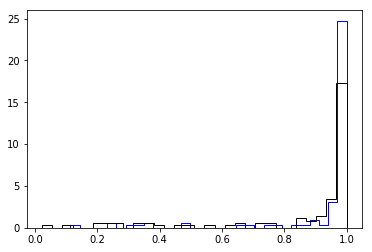

In [43]:
plt.hist(allKois.reliability, 30, histtype="step", color="b", density=True);
plt.hist(allKois.totalReliability, 30, histtype="step", color="k", density=True);

In [44]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [45]:
%%bash -s 
jupyter nbconvert --to html computeOccurrenceGap.ipynb
mv computeOccurrenceGap.html htmlArchive/computeOccurrenceGap.html

[NbConvertApp] Converting notebook computeOccurrenceGap.ipynb to html
[NbConvertApp] Writing 1801237 bytes to computeOccurrenceGap.html
